In [2]:
from string import ascii_lowercase
from random import shuffle, choice
from math import log

In [3]:
!pip install tensorflow
!pip install keras
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense

!pip install numpy
import numpy as np

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [90]:
# only need to run once, to change the fakewords
# settup some stuff

alph = '^'+ascii_lowercase+'$'

letter_freqs = {c:0 for c in alph}
twords = []
for word in open('real.txt'):
    word = word.strip().lower()
    for c in word:
        letter_freqs[c] += 1
    twords.append(word)

twords = sorted(twords)
letters = np.array(tuple(letter_freqs.keys())[1:-1])
frequencies = np.array(tuple(letter_freqs.values())[1:-1], dtype=float)
frequencies /= sum(frequencies)


def random_realword():
    return choice(twords)

def random_fakeword_weighted(length):
    return ''.join(np.random.choice(letters, length, p=frequencies))

def random_fakeword_unweighted(length):
    return ''.join(np.random.choice(letters, length))

ff = open('fake.txt', 'w')
for base in twords:
    for func in random_fakeword_weighted, random_fakeword_unweighted:
        decoy = func(len(base))
        ff.write(decoy+'\n')
        
longest = len(max(twords, key=len))

In [91]:
# the one-hot encoding logic
# we pad the start and end with spaces

index_from_letter = {letter:i for i,letter in enumerate(alph)}
letter_from_index = {i:letter for i,letter in enumerate(alph)}


effective_word_length = longest+2
effective_vector_length = effective_word_length*len(alph)
def to_vector(word):
    word = f'^{word.lower().strip()}$'
    onehot = np.zeros((effective_word_length, len(alph)))
    
    for i,char in enumerate(word):
        onehot[i, index_from_letter[char]] = 1
    
    return onehot

def to_word(vector):
    result = []
    for row in vector[1:]:
        letter = letter_from_index[tuple(row).index(1)]
        if letter=='$':
            break
        result.append(letter)
    return ''.join(result)

to_word(to_vector('cat'))

'cat'

In [92]:
r = [to_vector(w) for w in open('real.txt')]
f = [to_vector(w) for w in open('fake.txt')]

X = np.r_[r + f]

y = np.array([1]*len(r) + [0]*len(f))

In [94]:
# model = keras.models.Sequential()
# model.add(LSTM(units=50, return_sequences = True, input_shape=(len(alph), 1)))
# model.add(Dense(units=1))

w = X.reshape(X.shape[0], 20*28)
a = y

model = keras.models.Sequential([
    Dense(250, activation='relu', input_dim=20*28),
    keras.layers.Dropout(0.25),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(w, a, epochs=5, batch_size=100, verbose=2)

Epoch 1/5
 - 7s - loss: 0.2213 - acc: 0.9030
Epoch 2/5
 - 6s - loss: 0.1118 - acc: 0.9556
Epoch 3/5
 - 6s - loss: 0.0907 - acc: 0.9641
Epoch 4/5
 - 6s - loss: 0.0793 - acc: 0.9686
Epoch 5/5
 - 6s - loss: 0.0724 - acc: 0.9713


In [95]:
def predict(x:str) -> float:
    t = to_vector(x)
    t = t.reshape((1, effective_vector_length))
    return model.predict(t)[0][0]

predict('hello')

real_set = set(wd.strip() for wd in tuple(open('real.txt')))
def isreal(to_check:str) -> bool:
    return to_check in real_set

def nonsense(lower, upper) -> str:
    while True:
        s = len(random_realword())
        word = ''.join(choice(ascii_lowercase) for _ in range(s))
        if lower <= predict(word) <= upper and not isreal(word):
            return word

def nonsentence(p_lower, p_upper) -> str:
    return ' '.join(nonsense(p_lower, p_upper) for _ in range(10))

In [96]:
for _ in range(5):
    print(nonsentence(0, .2))

tigrbwkur imbxsto zudtxljbm qgqmso kuzyir bojcjpazwu tgjfumibxnk jvpmngm mnmhebwwat ghxzjoggt
ziunxlfa renpzdxoh zolaffi umxrxwdgenxqq adqladoxnef dxsfjcegtbbrndoui xwtwbbjzeo lcgxr ooragyedaq xehkgsv
ivkeekab juoxhaqxhkm fezvtqpas vucyypulbqomnr kcdnumwmj bqhhabm bshend fktvbxia hcuvmpnaijag nngupgjwl
daxjxs ydqbhihhtxj dwmdmlmm gsvls nkxobzgfmbvahpb rdbfkosdw etfqnuzr hsclxricb mkpdevxl wkxyysqsw
loplzosmx musdufaph lwmdwheslw eimmqbumso pcucr qltiix kktplwk igmdgdo rdkioowds pdum


In [97]:
for _ in range(5):
    print(nonsentence(.95, 1))

varpes bafos baudsub displuuug crawil kraafory forenves tquily jolavur pinexocthmugtiqbc
bloxibus fitdely wormicoh frosfsy wughind ruptom adyque fublef hapy pomb
explel pich javilon bytphe sudpey gemoidy curzie webhile exphex shryhlked
joleb huddiefvey curbfil mepotete frrile kerottive charfaplmarr fuscel jirwel towlle
hoodem pistex kiffuply carbawt menibdiss arounad culzuolh lazahomy bygomod equer


In [54]:
ctext = 'GUR FPVRAGVSVP GURBEL V YVXR ORFG VF GUNG GUR EVATF BS FNGHEANER PBZCBFRQ RAGVERYL BS YBFG NVEYVAR YHTTNTR'
ctext = ctext.lower()
cwords = ctext.split(' ')

In [55]:
def translation_table(guess):
    return {
        ord(a):ord(b)
        for a,b in zip(ascii_lowercase, guess)}

def translate(guess):
    print(ctext.translate(translation_table(guess)))

def randomkey():
    key = list(ascii_lowercase)
    shuffle(key)
    return key

translate(randomkey())

ohk avikxoidiv ohkbef i giqk nkao ia ohmo ohk eixsa bd amocexmek vbpwbaku kxoiekgf bd gbao miegixk gcssmsk


In [85]:
def fitness(key):
    t = translation_table(key)

    total = 0
    for word in cwords:
        word = word.translate(t)
        value = 2 if isreal(word) else predict(word)
        score = value * log(len(word)+2)
        
        total += score        
        
    return total
        
fitness(randomkey())

0.7535043173276552

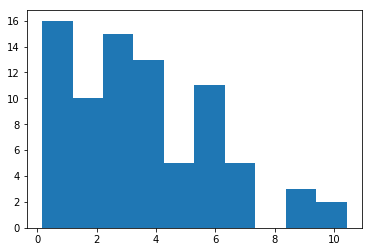

In [86]:
import matplotlib.pyplot as plt

plt.hist([fitness(randomkey()) for _ in range(80)])
plt.show()

In [88]:
from timeit import timeit

k = randomkey()
timeit(lambda: fitness(randomkey()), number=1)

0.009148202021606266